## Borough-Maps for the City of Vienna

For a better and more comprehensable represenation of regional election results in the city of Vienna, we aggregate the roughly 1.500 electoral districts into 137 boroughs. This notebook covers the necesarry steps for data collection, aggregation and a *very basic* visualisation for the presidential election 2022. The final result (including a more polished visualisation including a mapping for adresses) is available as part of our election coverage [here](). 

In [1]:
import pandas as pd
import geopandas as gpd
import json
import plotly.express as px
import plotly.graph_objects as go
import requests
import pyproj

### 1 - Geodata

The city of Vienna provides [geodata](https://www.data.gv.at/katalog/dataset/79c1030d-5cf6-4d58-ade6-02f66fb4dffb) for its electoral districts for each election since 2005. Since the population grows rather dynamically the electoral districts are not stable either and tend to change between elections. 

For the purpose of this notebook, we'll focus on the [presidential election 2022](https://www.data.gv.at/katalog/dataset/stadt-wien_wahleninwienbundesprsidentenwahlen/resource/57a7c05b-714b-4df8-8f83-987808145077).

#### 1.1 - Load Geodata for Electoral Districts

In [2]:
url_electoral_districts = "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:WAHLSPRBP2022OGD&srsName=EPSG:4326&outputFormat=json"
gdf_electoral_districts = gpd.read_file(url_electoral_districts)
gdf_electoral_districts.columns = gdf_electoral_districts.columns.str.lower()
gdf_electoral_districts["sprengel"] = gdf_electoral_districts["sprengel"].astype(int).astype(str)

#### 1.2 - Merge Electoral Districts into Boroughs

In [12]:
PATH_TO_MAPPING = "bp2022/mapping_graetzl_sprengel_bp2022.xlsx"
df_mapping = pd.read_excel(PATH_TO_MAPPING)
df_mapping.columns = df_mapping.columns.str.lower()
df_mapping.sprengel = df_mapping.sprengel.astype(int).astype(str)

gdf = gdf_electoral_districts.merge(df_mapping, on="sprengel", how="left")
gdf_boroughs = gdf.dissolve(by="graetzl_id").reset_index()

### 2 - Electoral Results

Result data is available in different granularities ranging from small electoral districts to larger constituencies and city districts for Viennese elections ([city](https://www.data.gv.at/katalog/dataset/fff27cd6-426c-479f-ae66-077ae6f1437d) and [city districts](https://www.data.gv.at/katalog/dataset/6eeef1f9-43a9-4fd4-bcb6-ac42981d9e74)) as well as [parliamentary](https://www.data.gv.at/katalog/dataset/b9193b21-6053-4de6-a118-d10380be8648), [presidential](https://www.data.gv.at/katalog/dataset/6981a9bd-d1fe-4b41-a8f8-2c5dc756975c) and [EP elections](https://www.data.gv.at/katalog/dataset/28d5df5c-5502-4373-81ba-6336ac517b9f).

#### 2.1 - Refine Result Data

For the purpose of this notebook, we'll use the [presidential election 2022](https://www.data.gv.at/katalog/dataset/stadt-wien_wahleninwienbundesprsidentenwahlen/resource/57a7c05b-714b-4df8-8f83-987808145077). The data presented in a wide tabular form that needs to be refined for further processing.

In [4]:
df_result_raw = pd.read_csv("https://www.wien.gv.at/wahlergebnis/ogd/BP221.csv", sep=";", encoding="latin1")
df_result_raw.columns = df_result_raw.columns.str.strip().str.lower()

df_result = df_result_raw[['typ', 'bezirk', 'districtcode', 'sprengelnummer', 'stimmtyp', 'erfassungseinheittyp',
       'wahlberechtigte', 'abgegebene stimmen', 'ungültige stimmen',
       'dr. michael brunner', 'gerald grosz', 'dr. walter rosenkranz',
       'heinrich staudinger', 'dr. alexander van der bellen',
       'dr. tassilo wallentin', 'dr. dominik wlazny', 'status',]]

candidate_cols = ['dr. michael brunner', 'gerald grosz', 'dr. walter rosenkranz',
       'heinrich staudinger', 'dr. alexander van der bellen',
       'dr. tassilo wallentin', 'dr. dominik wlazny',]

meta_cols = ['typ', 'bezirk', 'districtcode', 'sprengelnummer', 'stimmtyp', 'erfassungseinheittyp', 
             'wahlberechtigte', 'abgegebene stimmen', 'ungültige stimmen', 'status']

# Transpose wide dataframe to long dataframe
for candidate in candidate_cols:
    df_result = df_result.rename(columns={candidate: "votes_"+candidate})
df_result_long = pd.wide_to_long(df_result, i=meta_cols, stubnames="votes", sep="_", j="candidate", suffix="\D+").reset_index()

# Calculate vote shares for each candidate
df_result_long["valid"] = df_result_long["abgegebene stimmen"]-df_result_long["ungültige stimmen"]
df_result_long["share"] = df_result_long["votes"]/df_result_long["valid"]*100

#### 2.2 - Calculate Mutual District ID

Each electoral district is conveniently identified by a unique ID. But in order to not get too convenient, those IDs are represented in different forms accross different data sources. Thus, before merging election results with geodata, we need to calculate a mutual district ID for result data and geodata. 

In [16]:
def encode_electoral_districts(df_result_full):
    df_result = df_result_full[~df_result_full.sprengelnummer.isna()]
    df_result["districtcode"]=df_result.districtcode.astype(int).astype(str).str[1:3].astype(int).astype(str)
    df_result["sprengelnummer"] = df_result.sprengelnummer.astype(int).astype(str).str.zfill(3)
    df_result["sprengel"] = (df_result["districtcode"]+df_result["sprengelnummer"]).astype(str)
    return df_result

df_result_districts = encode_electoral_districts(df_result_long.loc[df_result_long.typ=="Sprengel"])

#### 2.3 Merge Election Results into Geodata

In [28]:
df_result_boroughs = pd.merge(df_result_districts, df_mapping, on="sprengel", how="left").groupby(["bezirk", "graetzl_id", "graetzl_name", "candidate"]).agg({"valid": "sum", "votes": "sum"}).reset_index()
df_result_boroughs.columns = df_result_boroughs.columns.str.lower()
df_result_boroughs["share"] = df_result_boroughs["votes"]/df_result_boroughs["valid"]*100

### 3 - Basic Borough Map

Last, we'll create a basic plot based on the election results of encumbent president Alexander Van der Bellen. 

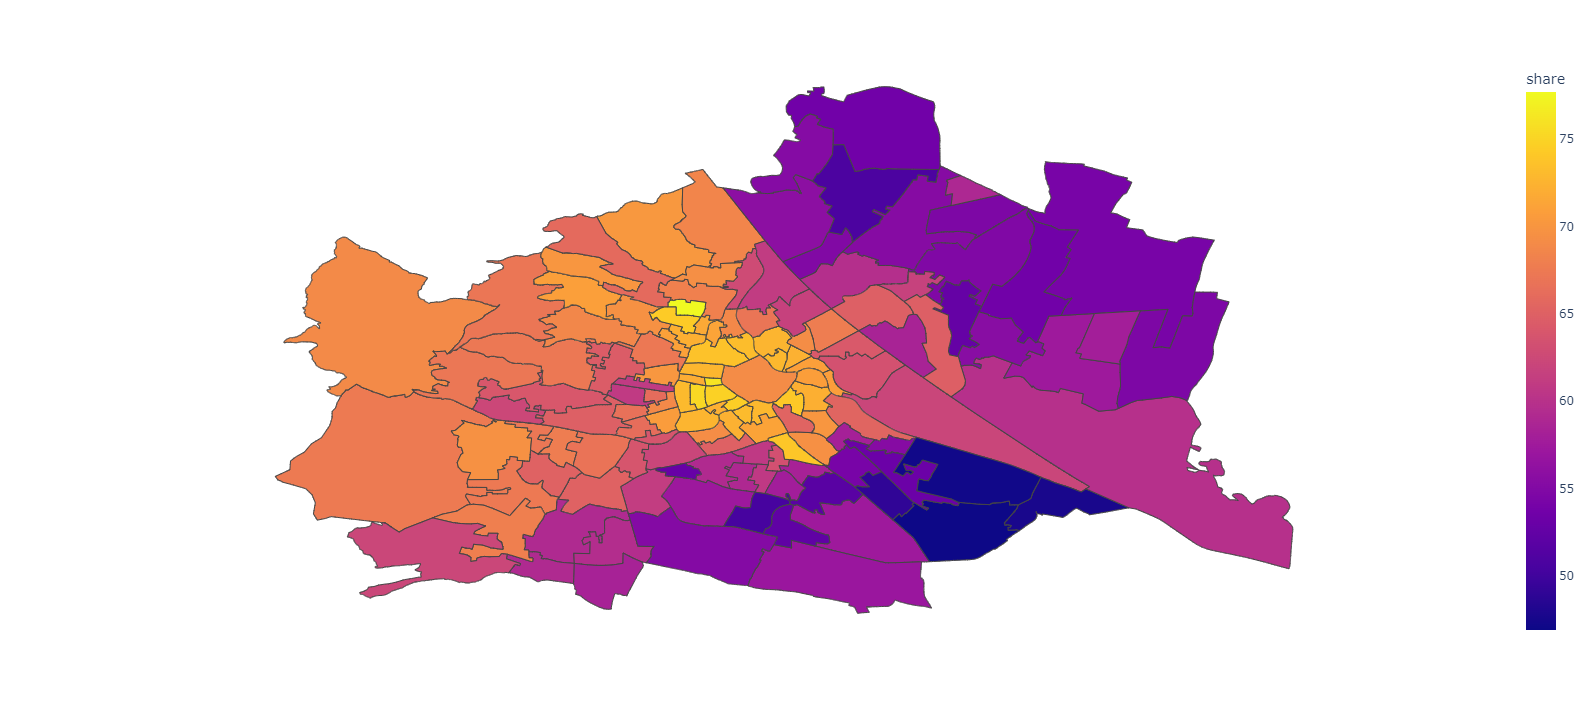

In [21]:
def plot_result_map(candidate, df_result, gdf):
    gdf.graetzl_id = gdf.graetzl_id.astype(int)
    df_result.graetzl_id = df_result.graetzl_id.astype(int) 
    merged = gdf.merge(df_result.loc[df_result.candidate==candidate], on="graetzl_id")
    merged = merged.set_index("graetzl_id")
    
    fig = px.choropleth(merged, geojson=merged.__geo_interface__, locations=merged.index, color="share")
    fig.update_geos(fitbounds="locations", visible=False)
    return fig

candidate = "dr. alexander van der bellen"
fig = plot_result_map(candidate, df_result_boroughs, gdf_boroughs)
fig.show()

In [ ]:
fig.update